In [ ]:
import pandas as pd
from google.colab import drive

# Open file dialog to upload CSV file
# uploaded = files.upload()
df=pd.read_csv("merged_reviews.csv")

In [ ]:
!pip install s3fs==2023.9.2
!pip install -q vaderSentiment
!pip install seaborn
!pip install numpy==1.26.1
!python -m spacy download en_core_web_lg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
import gc
import plotly.express as px
warnings.filterwarnings('ignore')



# Check basic data info
print(df.info())
print(df.describe())
gc.collect()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.9.2 which is incompatible.
torch 2.5.

30

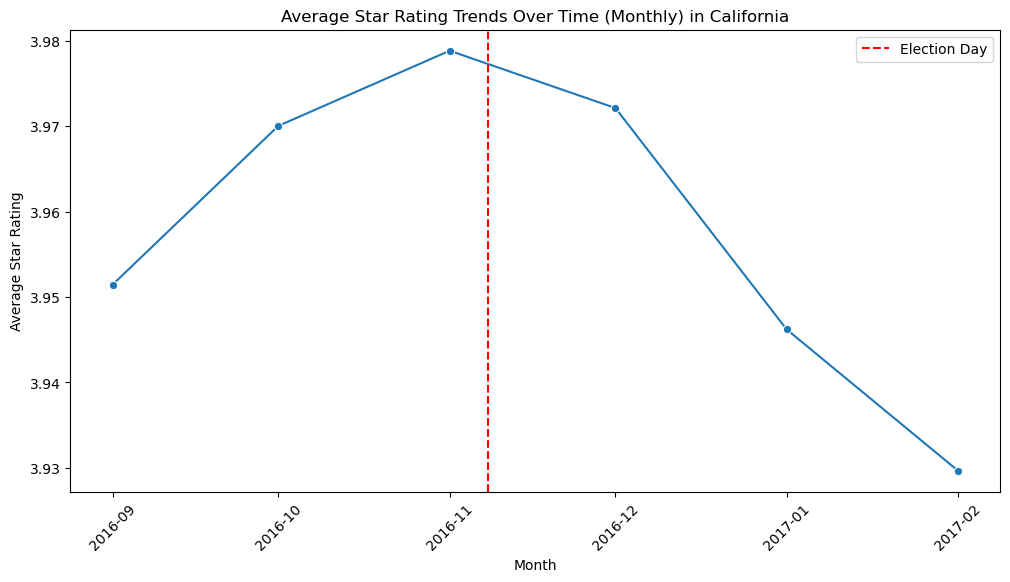

In [ ]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter for businesses in California (CA)
df_ca = df[df['state'] == 'CA']

# Aggregate data by month and calculate the mean star rating for each month
df_ca['month'] = df_ca['date'].dt.to_period("M")  # Extract month
monthly_stars = df_ca.groupby('month')['stars'].mean().reset_index()

# Convert 'month' back to datetime for plotting
monthly_stars['month'] = monthly_stars['month'].astype(str)
monthly_stars['month'] = pd.to_datetime(monthly_stars['month'])

# Plot monthly average star rating trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_stars, x='month', y='stars', marker='o')

# Mark election day
plt.axvline(pd.to_datetime("2016-11-08"), color='red', linestyle='--', label="Election Day")

plt.title("Average Star Rating Trends Over Time (Monthly) in California")
plt.xlabel("Month")
plt.ylabel("Average Star Rating")
plt.xticks(rotation=45)
plt.legend()

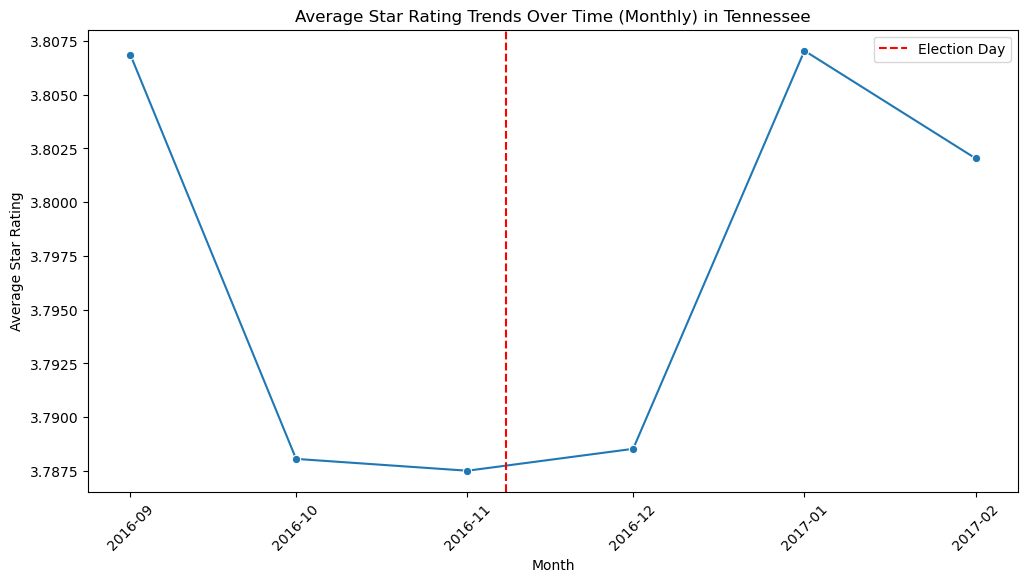

In [ ]:
# Filter for businesses in California (CA)
df_ca = df[df['state'] == 'TN']

# Aggregate data by month and calculate the mean star rating for each month
df_ca['month'] = df_ca['date'].dt.to_period("M")  # Extract month
monthly_stars = df_ca.groupby('month')['stars'].mean().reset_index()

# Convert 'month' back to datetime for plotting
monthly_stars['month'] = monthly_stars['month'].astype(str)
monthly_stars['month'] = pd.to_datetime(monthly_stars['month'])

# Plot monthly average star rating trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_stars, x='month', y='stars', marker='o')

# Mark election day
plt.axvline(pd.to_datetime("2016-11-08"), color='red', linestyle='--', label="Election Day")

plt.title("Average Star Rating Trends Over Time (Monthly) in Tennessee")
plt.xlabel("Month")
plt.ylabel("Average Star Rating")
plt.xticks(rotation=45)
plt.legend()
plt.show()


The longest review has: 941 words


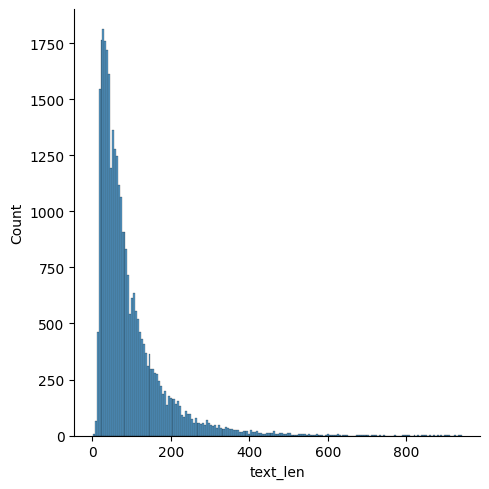

In [ ]:
df2 = df[["date", "text", "stars", "state"]].copy()
# Create a new column containing the length each headline text
df2['sentiment'] = df2['stars'].apply(lambda x: 'negative' if x < 3 else ('neutral' if x < 4 else 'positive'))


df2["text_len"] = df2["text"].apply(lambda x : len(x.split()))

print("The longest review has: {} words".format(df2.text_len.max()))
df2.head()
sns.displot(df2.text_len, kde=False)

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 843.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
#####approach 3 combine Umap with Zero-shot(Win/Lose)Topic 10
from umap import UMAP
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

# UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

# Define zero-shot topic list
zeroshot_topic_list = ["Win", "Lose"]

# Initialize BERTopic with zero-shot guidance
topic_model = BERTopic(
    embedding_model="thenlper/gte-small",
    umap_model=umap_model,  # Use UMAP for dimensionality reduction
    min_topic_size=10, #tweak
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=0.75,  # Allows flexibility
    representation_model=KeyBERTInspired(),
    language="english",
    calculate_probabilities=True
)

# Fit model to text data
topics, probabilities = topic_model.fit_transform(df2.text)

In [ ]:
topic_info = topic_model.get_topic_info()
num_topics = len(topic_info)
freq = topic_model.get_topic_info()
print("Number of topics: {}".format( len(freq)))

Number of topics: 9


In [ ]:
topic_model.get_document_info(df2.text)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Waited several minutes waiting to order. I was...,0,Win,"[restaurant, food, delicious, fresh, amazing, ...",[It was pretty good. \n\nWe were seated quickl...,restaurant - food - delicious - fresh - amazin...,0.885665,False
1,"Ordered online, quoted 26-36 min, delivered al...",0,Win,"[restaurant, food, delicious, fresh, amazing, ...",[It was pretty good. \n\nWe were seated quickl...,restaurant - food - delicious - fresh - amazin...,0.877464,False
2,What a great addition to the Funk Zone! Grab ...,0,Win,"[restaurant, food, delicious, fresh, amazing, ...",[It was pretty good. \n\nWe were seated quickl...,restaurant - food - delicious - fresh - amazin...,0.907389,False
3,Possibly the best breakfast sandwich EVER. On...,0,Win,"[restaurant, food, delicious, fresh, amazing, ...",[It was pretty good. \n\nWe were seated quickl...,restaurant - food - delicious - fresh - amazin...,0.900274,False
4,"Super slow service, ""salads"" are not very good...",1,Lose,"[restaurant, food, service, went, took, bad, s...","[In short: OK food, extremely bad service.\n\n...",restaurant - food - service - went - took - ba...,0.903731,False
...,...,...,...,...,...,...,...,...
31917,My wife and I came into The Melting Pot on Chr...,1,Lose,"[restaurant, food, service, went, took, bad, s...","[In short: OK food, extremely bad service.\n\n...",restaurant - food - service - went - took - ba...,0.923633,False
31918,The Melting Pot is a classic. At this location...,0,Win,"[restaurant, food, delicious, fresh, amazing, ...",[It was pretty good. \n\nWe were seated quickl...,restaurant - food - delicious - fresh - amazin...,0.917728,False
31919,"Hubby and I fine dine often, and this year for...",1,Lose,"[restaurant, food, service, went, took, bad, s...","[In short: OK food, extremely bad service.\n\n...",restaurant - food - service - went - took - ba...,0.913387,False
31920,This place is a classic in Nashville! I've bee...,0,Win,"[restaurant, food, delicious, fresh, amazing, ...",[It was pretty good. \n\nWe were seated quickl...,restaurant - food - delicious - fresh - amazin...,0.906320,False


In [ ]:
# Visualize the barchart
fig = topic_model.visualize_barchart(top_n_topics=10,n_words=10,height = 500)
# Display the figure explicitly
fig.show()

In [ ]:
# Visualize the barchart
fig = topic_model.visualize_topics(top_n_topics=20)
# Display the figure explicitly
fig.show()

In [ ]:
# Adjust the format to include time and timezone
df2['date_format'] = pd.to_datetime(df2['date'], format='%Y-%m-%d %H:%M:%S')

# Create topics over time
topics_over_time = topic_model.topics_over_time(df2.text, timestamps=df2['date_format'], nr_bins=20)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics = [0,1,2,3,4,5,6,7])

In [ ]:
CA = df2[df2["state"] == "CA"].copy()  # Ensure CA is an independent DataFrame
CA = CA.dropna(subset=["text", "date_format"])  # Remove rows with missing values
CA["date_format"] = pd.to_datetime(CA["date_format"], errors="coerce")  # Convert to datetime
CA = CA.reset_index(drop=True)  # Reset index

# Fit BERTopic model
ca_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
topics, probabilities = ca_model.fit_transform(CA["text"])

# Generate topics over time
topics_over_time = ca_model.topics_over_time(CA["text"], timestamps=CA["date_format"], nr_bins=20)

# Visualize
ca_model.visualize_topics_over_time(topics_over_time, topics=[0,1,3,4,5,6,7,8,9])

In [ ]:
TN = df2[df2["state"] == "TN"].copy()  # Filter for Tennessee data
TN = TN.dropna(subset=["text", "date_format"])  # Remove rows with missing values
TN["date_format"] = pd.to_datetime(TN["date_format"], errors="coerce")  # Convert to datetime
TN = TN.reset_index(drop=True)  # Reset index

# Fit BERTopic model
tn_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
topics, probabilities = tn_model.fit_transform(TN["text"])

# Generate topics over time
topics_over_time = tn_model.topics_over_time(TN["text"], timestamps=TN["date_format"], nr_bins=20)

# Visualize
tn_model.visualize_topics_over_time(topics_over_time, topics=[0,1,3,4,5,6,7,8,9])

In [ ]:
import plotly.express as px
# Step 1: Filter for California data
CA = df2[df2["state"] == "CA"].copy()  # Ensure CA is an independent DataFrame
CA = CA.dropna(subset=["text", "date_format", "stars"])  # Remove rows with missing values
CA["date_format"] = pd.to_datetime(CA["date_format"], errors="coerce")  # Convert to datetime
CA = CA.reset_index(drop=True)  # Reset index

# Step 2: Fit BERTopic model
ca_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
topics, probabilities = ca_model.fit_transform(CA["text"])

# Step 3: Add topics to the DataFrame
CA['topic'] = topics

# Step 4: Filter for selected topics (e.g., 2, 3, 4, 5, 6, 8, 9)
selected_topics = [0,1,3,4,5,6,7]
selected_topic_data = CA[CA['topic'].isin(selected_topics)].copy()

# Step 5: Group by time and topic, and calculate the average star rating for each
stars_over_time = selected_topic_data.groupby([selected_topic_data["date_format"].dt.to_period("M"), "topic"])["stars"].mean().reset_index()
stars_over_time["date_format"] = stars_over_time["date_format"].astype(str)  # Convert to string for plotting

# Step 6: Visualize the star rating shift over time for selected topics
fig = px.line(stars_over_time, x="date_format", y="stars", color="topic",
              title="Shift in Star Ratings of Selected Topics Over Time in CA",
              labels={"date_format": "Time (Month)", "stars": "Average Star Rating", "topic": "Topic"},
              markers=True)

fig.show()

In [ ]:
TN = df2[df2["state"] == "TN"].copy()  # Ensure TN is an independent DataFrame
TN = TN.dropna(subset=["text", "date_format", "stars"])  # Remove rows with missing values
TN["date_format"] = pd.to_datetime(TN["date_format"], errors="coerce")  # Convert to datetime
TN = TN.reset_index(drop=True)  # Reset index

# Step 2: Fit BERTopic model for Tennessee reviews
tn_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
topics, probabilities = tn_model.fit_transform(TN["text"])

# Step 3: Add topics to the DataFrame
TN['topic'] = topics

# Step 4: Filter for selected topics (e.g., 2, 3, 4, 5, 6, 8, 9)
selected_topics = [0,1,3,4,5,6,7]
selected_topic_data = TN[TN['topic'].isin(selected_topics)].copy()

# Step 5: Group by time and topic, and calculate the average star rating for each
stars_over_time = selected_topic_data.groupby([selected_topic_data["date_format"].dt.to_period("M"), "topic"])["stars"].mean().reset_index()
stars_over_time["date_format"] = stars_over_time["date_format"].astype(str)  # Convert to string for plotting

# Step 6: Visualize the star rating shift over time for selected topics in Tennessee
fig = px.line(stars_over_time, x="date_format", y="stars", color="topic",
              title="Shift in Star Ratings of Selected Topics Over Time in Tennessee",
              labels={"date_format": "Time (Month)", "stars": "Average Star Rating", "topic": "Topic"},
              markers=True)

fig.show()


In [ ]:
fig = topic_model.visualize_hierarchy(top_n_topics=10)
fig.show()
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,129,-1_food_delicious_overall_sushi,"[food, delicious, overall, sushi, friendly, pl...",[First and foremost the food here is great... ...
1,0,23697,Win,"[nashville, restaurant, food, delicious, amazi...",[We were so excited to hear John Besh was open...
2,1,7774,Lose,"[restaurant, food, bad, went, service, server,...",[Ummmmmmm? Everyone raved about this place so ...
3,2,25,2_burger_burgers_fries_delicious,"[burger, burgers, fries, delicious, food, tast...",[It's family owned and the super nice son of t...
4,3,180,3_restaurant_service_food_overall,"[restaurant, service, food, overall, server, b...","[Service is typically hit and miss, with food ..."
5,4,14,4_restaurant_tacos_burrito_delicious,"[restaurant, tacos, burrito, delicious, food, ...",[This is my go-to favorite Mexican Restaurant....
6,5,18,5_cafe_breakfast_coffee_delicious,"[cafe, breakfast, coffee, delicious, latte, ko...","[Since I last came here, they seem to have exp..."
7,6,14,6_restaurant_restaurants_vegetarian_vegetarians,"[restaurant, restaurants, vegetarian, vegetari...",[I'm not a vegetarian and I love this place as...
8,7,71,7_restaurant_delicious_food_dinner,"[restaurant, delicious, food, dinner, amazing,...",[Found this place on yelp and wasn't disappoin...


In [ ]:
docs = df2['text']
stars = df2['stars']

topics_per_stars = topic_model.topics_per_class(docs, classes=stars)

fig = topic_model.visualize_topics_per_class(topics_per_stars)

fig.show()

In [ ]:
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic
from umap import UMAP
# Initiate UMAP
umap_model = UMAP(n_neighbors=20,
                  n_components=7,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)
# Initiate BERTopic
model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
# Run BERTopic model
headline_topics, probabilities = model.fit_transform(df2.text)

In [ ]:
headline_topics[:5]

In [ ]:
probabilities[:5]

In [ ]:
model.get_document_info(df2.text)

In [ ]:
# Visualize the barchart
fig = model.visualize_barchart(top_n_topics=10,n_words=10,height = 500)
# Display the figure explicitly
fig.show()



In [ ]:
# Visualize the barchart
fig = model.visualize_topics(top_n_topics=20)
# Display the figure explicitly
fig.show()

In [ ]:
model.probabilities_[0]

In [ ]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))

In [ ]:
a_topic = freq.iloc[2]["Topic"] # Select the 1st topic
model.get_topic(a_topic)

In [ ]:
# Adjust the format to include time and timezone
df2['date_format'] = pd.to_datetime(df2['date'], format='%Y-%m-%d %H:%M:%S')

# Create topics over time
topics_over_time = model.topics_over_time(df2.text, timestamps=df2['date_format'], nr_bins=20)

In [ ]:
model.visualize_topics_over_time(topics_over_time, topics = [2,3,4,5,6,8,9])

In [ ]:
CA = df2[df2["state"] == "CA"].copy()  # Ensure CA is an independent DataFrame
CA = CA.dropna(subset=["text", "date_format"])  # Remove rows with missing values
CA["date_format"] = pd.to_datetime(CA["date_format"], errors="coerce")  # Convert to datetime
CA = CA.reset_index(drop=True)  # Reset index

# Fit BERTopic model
ca_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
topics, probabilities = ca_model.fit_transform(CA["text"])

# Generate topics over time
topics_over_time = ca_model.topics_over_time(CA["text"], timestamps=CA["date_format"], nr_bins=20)

# Visualize
ca_model.visualize_topics_over_time(topics_over_time, topics=[2, 3, 4, 5, 6, 8, 9])

In [ ]:
TN = df2[df2["state"] == "TN"].copy()  # Filter for Tennessee data
TN = TN.dropna(subset=["text", "date_format"])  # Remove rows with missing values
TN["date_format"] = pd.to_datetime(TN["date_format"], errors="coerce")  # Convert to datetime
TN = TN.reset_index(drop=True)  # Reset index

# Fit BERTopic model
tn_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
topics, probabilities = tn_model.fit_transform(TN["text"])

# Generate topics over time
topics_over_time = tn_model.topics_over_time(TN["text"], timestamps=TN["date_format"], nr_bins=20)

# Visualize
tn_model.visualize_topics_over_time(topics_over_time, topics=[2, 3, 4, 5, 6, 8, 9])


In [ ]:
# Step 1: Filter for California data
CA = df2[df2["state"] == "CA"].copy()  # Ensure CA is an independent DataFrame
CA = CA.dropna(subset=["text", "date_format", "stars"])  # Remove rows with missing values
CA["date_format"] = pd.to_datetime(CA["date_format"], errors="coerce")  # Convert to datetime
CA = CA.reset_index(drop=True)  # Reset index

# Step 2: Fit BERTopic model
ca_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
topics, probabilities = ca_model.fit_transform(CA["text"])

# Step 3: Add topics to the DataFrame
CA['topic'] = topics

# Step 4: Filter for selected topics (e.g., 2, 3, 4, 5, 6, 8, 9)
selected_topics = [2, 3, 4, 5, 6, 8, 9]
selected_topic_data = CA[CA['topic'].isin(selected_topics)].copy()

# Step 5: Group by time and topic, and calculate the average star rating for each
stars_over_time = selected_topic_data.groupby([selected_topic_data["date_format"].dt.to_period("M"), "topic"])["stars"].mean().reset_index()
stars_over_time["date_format"] = stars_over_time["date_format"].astype(str)  # Convert to string for plotting

# Step 6: Visualize the star rating shift over time for selected topics
fig = px.line(stars_over_time, x="date_format", y="stars", color="topic",
              title="Shift in Star Ratings of Selected Topics Over Time in CA",
              labels={"date_format": "Time (Month)", "stars": "Average Star Rating", "topic": "Topic"},
              markers=True)

fig.show()


In [ ]:
TN = df2[df2["state"] == "TN"].copy()  # Ensure TN is an independent DataFrame
TN = TN.dropna(subset=["text", "date_format", "stars"])  # Remove rows with missing values
TN["date_format"] = pd.to_datetime(TN["date_format"], errors="coerce")  # Convert to datetime
TN = TN.reset_index(drop=True)  # Reset index

# Step 2: Fit BERTopic model for Tennessee reviews
tn_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)
topics, probabilities = tn_model.fit_transform(TN["text"])

# Step 3: Add topics to the DataFrame
TN['topic'] = topics

# Step 4: Filter for selected topics (e.g., 2, 3, 4, 5, 6, 8, 9)
selected_topics = [2, 3, 4, 5, 6, 8, 9]
selected_topic_data = TN[TN['topic'].isin(selected_topics)].copy()

# Step 5: Group by time and topic, and calculate the average star rating for each
stars_over_time = selected_topic_data.groupby([selected_topic_data["date_format"].dt.to_period("M"), "topic"])["stars"].mean().reset_index()
stars_over_time["date_format"] = stars_over_time["date_format"].astype(str)  # Convert to string for plotting

# Step 6: Visualize the star rating shift over time for selected topics in Tennessee
fig = px.line(stars_over_time, x="date_format", y="stars", color="topic",
              title="Shift in Star Ratings of Selected Topics Over Time in Tennessee",
              labels={"date_format": "Time (Month)", "stars": "Average Star Rating", "topic": "Topic"},
              markers=True)

fig.show()


In [ ]:
df_CA = df[df["state"] == "CA"][["date", "text"]].copy()
# Create a new column containing the length each headline text
df_CA["text_len"] = df_CA["text"].apply(lambda x : len(x.split()))
df_CA.head()

In [ ]:
df_CA_text = df[df["state"] == "CA"][['text']];
print("The longest review has: {} words".format(df_CA.text_len.max()))

In [ ]:
# Visualize the length distribution

sns.displot(df_CA.text_len, kde=False)

In [ ]:
sampled_reviews = df_CA.sample(3)

# Iterate over the sampled rows
for idx, review in sampled_reviews.iterrows():
    print("Review #{}:".format(idx))
    print("Publication date: {}".format(review["date"]))
    print("Text: {}\n".format(review["text"]))

In [ ]:
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic
import pandas as pd

zeroshot_topic_list_CA = ["win", "lose"]

# We fit our model using the zero-shot topics

topic_model_CA = BERTopic(
    embedding_model="thenlper/gte-small",
    min_topic_size=5,
    zeroshot_topic_list=zeroshot_topic_list_CA,
    zeroshot_min_similarity=.75,
    representation_model=KeyBERTInspired()
)
# Corrected line: fit the model on df_CA.text
topics, probabilities = topic_model_CA.fit_transform(df_CA.text)
# Now that we have fit the topic model, assign the topics to the model
topic_model_CA.topics_ = topics
topic_model_CA.probabilities_ = probabilities
# Corrected line: pass in the training data to get_document_info()
document_info = topic_model_CA.get_document_info(df_CA.text)
print(document_info.head())

In [ ]:
topic_model_CA.get_topic_info()

In [ ]:
topic_model_CA.get_topic(0)

In [ ]:
topic_model_CA.get_document_info(df_CA.text)

In [ ]:
topics = topic_model_CA.topics_
topics[:10]
topic_model_CA.probabilities_[:10]

In [ ]:
freq = topic_model_CA.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head()

#Topics Visualization

In [ ]:
import plotly.io as pio

# Set the default renderer for Jupyter
pio.renderers.default = 'colab'

#Topic Terms

In [ ]:
# Visualize the barchart
fig = topic_model_CA.visualize_barchart(top_n_topics=10, n_words=10, height=500)
# Display the figure explicitly
fig.show()

In [ ]:
# Visualize the barchart
fig = topic_model_CA.visualize_topics(top_n_topics=10)

# Display the figure explicitly

fig.show()

In [ ]:
# Adjust the format to include time and timezone
df_CA['date_format'] = pd.to_datetime(df_CA['date'], format='%Y-%m-%d %H:%M:%S %z')

# Reset the index of df_CA
df_CA = df_CA.reset_index(drop=True)

# Create topics over time
topics_over_time = topic_model_CA.topics_over_time(df_CA.text, timestamps=df_CA['date_format'], nr_bins=20)

In [ ]:
topic_model_CA.visualize_topics_over_time(topics_over_time, topics = [0, 1, 2, 3, 4, 5])